In [1]:
import os
import random
from matplotlib import pyplot as plt
import skimage
import sklearn
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torchvision

%run ../metric_dissimilarity.py

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/lucas/.miniconda/envs/torch/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Read the images
X = []
Y = []

for cls in os.listdir("data/processed"):
  for img_filename in os.listdir(f"data/processed/{cls}"):
    img = skimage.io.imread(f"data/processed/{cls}/{img_filename}")
    X.append(img)
    Y.append(cls)

# Convert to numpy
X = np.array(X, dtype = np.uint8)
Y = sklearn.preprocessing.LabelEncoder().fit_transform(Y)

# Split the data
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, random_state = 42, stratify = Y)

In [3]:
np.random.seed(seed)
open_set = {}
for k_openset in range(5, 0, -1):
  open_set[k_openset] = {}
  size = round(len(np.unique(Y)) * (k_openset / 10))
  for kfold in range(5):
    open_set[k_openset][kfold] = np.random.choice(np.unique(Y), size = size, replace = False)

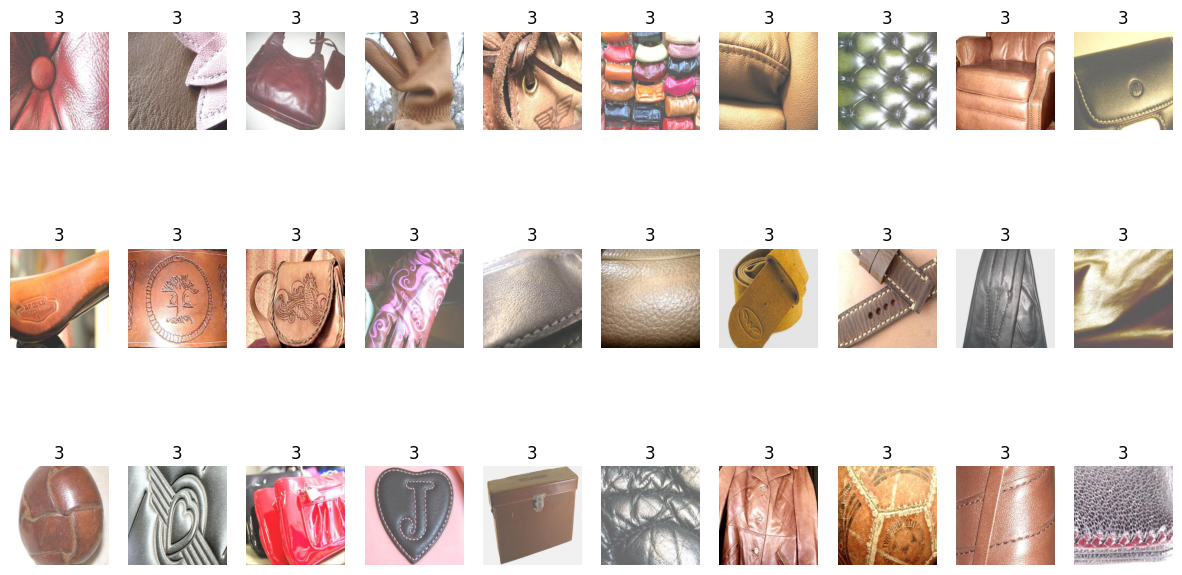

In [4]:
# Visualize some images and their corresponding labels.
plt.figure(figsize = (15, 8))
for i in range(30):
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(X[i] / 255.)
  plt.title(Y[i])
  plt.axis("off")

In [5]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images, labels, augment = True):
    self.images = images
    self.labels = labels
    self.augment = augment

    self.transform = A.Compose([
      A.RandomCrop(200, 200),
      A.HorizontalFlip(),
      A.VerticalFlip(),
      A.Rotate(),
      A.GaussianBlur(),
      A.RandomBrightnessContrast(),
      ToTensorV2()
    ])

    self.test_transform = A.Compose([
      A.CenterCrop(200, 200),
      ToTensorV2()
    ])

  def __len__(self):
     return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]

    if self.augment:
      image = self.transform(image = image)["image"]
    else:
      image = self.test_transform(image = image)["image"]

    image = image / 255.

    return image, label

In [6]:
class EffNet(torch.nn.Module):
  def __init__(self, n_classes):
    super(EffNet, self).__init__()

    # Load EfficientNetV2-S as the shared network
    self.network = torchvision.models.get_model("efficientnet_v2_s", weights = "DEFAULT")

    # Freeze the base network
    for param in self.network.parameters():
      param.requires_grad = False

    # Replace the last classification layer with a set of custom layers
    self.network.classifier = torch.nn.Sequential(
      torch.nn.Linear(self.network.classifier[1].in_features, 512),
      torch.nn.ReLU(),
      torch.nn.Dropout(p = 0.2),
      torch.nn.Linear(512, 256),
      torch.nn.ReLU(),
      torch.nn.Dropout(p = 0.2),
      torch.nn.Linear(256, n_classes)
    )

  def forward(self, x):
    # Pass the input through the shared network
    x = self.network(x)
    return x

  def freeze_network(self):
    for param in self.network.parameters():
      param.requires_grad = False

  def unfreeze_network(self):
    for param in self.network.parameters():
      param.requires_grad = True

In [7]:
def train_model(X, Y, model_id, batch_size = 32, epochs = 600):

  # Define the model filename based on model_id
  model_filename = f"models/baseline_{model_id}.pth"
  print(model_filename)

  # Define computation device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Recode the output since some classes might have been removed
  Y = sklearn.preprocessing.LabelEncoder().fit_transform(Y)

  # Initialize model and optimizer
  n_classes = len(np.unique(Y))
  effnet = None

  # Load pre-trained model if exists
  if os.path.isfile(model_filename):
    effnet = EffNet(n_classes)
    effnet.load_state_dict(torch.load(model_filename, weights_only = True))
    effnet.to(device)

  # Train a new model if not loaded
  if effnet is None:

    dtd = ImageDataset(X, Y)
    train_loader = torch.utils.data.DataLoader(dtd, batch_size = batch_size, shuffle = True)

    effnet = EffNet(n_classes)
    effnet.to(device)

    # Initialize loss, optimizer, and training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(effnet.parameters(), lr = 0.1, momentum = 0.9)
    effnet.train()

    # Warmup top layers
    epoch_loss = 0
    for epoch in range(20):
      for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = effnet(images)

        # Compute loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

      # Compute average epoch loss
      print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")
      epoch_loss = 0

    # Unfreeze the network
    effnet.unfreeze_network()

    # Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Add a learning rate scheduler with linear warmup
    optimizer = torch.optim.SGD(effnet.parameters(), lr = 0.01, momentum = 0.9)

    lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 0.001, total_iters = 20)
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = (epochs // 3))
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers = [lr_scheduler, cosine_scheduler], milestones = [20])

    # Train
    epoch_loss = 0
    for epoch in range(epochs):
      for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = effnet(images)

        # Compute loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

      # Step scheduler
      scheduler.step()

      # Compute average epoch loss
      print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")
      epoch_loss = 0

    # Save the trained model
    torch.save(effnet.state_dict(), model_filename)

  # Freeze the model parameters
  for param in effnet.parameters():
    param.requires_grad = False

  # Set to evaluation mode
  effnet.eval()

  return effnet

In [8]:
# Model training
models = {}

# Iterate over the different openset splits
for k_openset in range(5, 0, -1):
  models[k_openset] = {}
  for kfold in range(5):

    # Remove the openset classes
    openset_indices = ~np.isin(Y_train, open_set[k_openset][kfold])
    X_train_open = X_train[openset_indices]
    Y_train_open = Y_train[openset_indices]

    # Unique model identifier
    model_id = f"fold-{kfold}_open-{k_openset}"

    # Train the model
    models[k_openset][kfold] = train_model(X_train_open, Y_train_open, model_id)

models/baseline_fold-0_open-5.pth
models/baseline_fold-1_open-5.pth
models/baseline_fold-2_open-5.pth
models/baseline_fold-3_open-5.pth
models/baseline_fold-4_open-5.pth
models/baseline_fold-0_open-4.pth
models/baseline_fold-1_open-4.pth
models/baseline_fold-2_open-4.pth
models/baseline_fold-3_open-4.pth
models/baseline_fold-4_open-4.pth
models/baseline_fold-0_open-3.pth
models/baseline_fold-1_open-3.pth
models/baseline_fold-2_open-3.pth
models/baseline_fold-3_open-3.pth
models/baseline_fold-4_open-3.pth
models/baseline_fold-0_open-2.pth
models/baseline_fold-1_open-2.pth
models/baseline_fold-2_open-2.pth
models/baseline_fold-3_open-2.pth
models/baseline_fold-4_open-2.pth
models/baseline_fold-0_open-1.pth
models/baseline_fold-1_open-1.pth
models/baseline_fold-2_open-1.pth
models/baseline_fold-3_open-1.pth
models/baseline_fold-4_open-1.pth


In [9]:
# Prediction
np.random.seed(1234)

# Iterate over the different openset splits
for k_openset in range(5, 0, -1):

  acc_overall = []
  msp_overall = []
  mls_overall = []

  # Iterate over the cross-validation splits
  for kfold in range(5):

    # Get unique classes used during training
    train_known_indices = ~np.isin(Y_train, open_set[k_openset][kfold])
    test_known_indices = ~np.isin(Y_test, open_set[k_openset][kfold])

    Y_train_known = Y_train[train_known_indices]

    # Make predictions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = ImageDataset(X_test, Y_test, augment=False)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

    logits = []
    with torch.no_grad():
      for images, _ in test_loader:
        images = images.to(device)
        logits.append(models[k_openset][kfold](images).cpu())

    # Concatenate logits
    logits = torch.cat(logits, dim=0)
    probs = torch.nn.functional.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

    # Convert back to numpy
    logits = logits.numpy()
    probs = probs.numpy()
    preds = preds.numpy()

    # Map the predictions to the known classes
    known_classes = np.unique(Y_train_known)
    preds = known_classes[preds]

    # Closed-set accuracy
    closed_acc = closed_accuracy(preds, Y_test, test_known_indices)

    # Open-set scores
    msp = compute_msp(probs)
    mls = compute_mls(logits)

    # AUROC
    msp_auroc = open_auroc(-msp, test_known_indices, ~test_known_indices)
    mls_auroc = open_auroc(-mls, test_known_indices, ~test_known_indices)

    acc_overall.append(closed_acc)
    msp_overall.append(msp_auroc)
    mls_overall.append(mls_auroc)

  # Print the overall results
  pct = lambda x: f"{x*100:.1f}%"
  fmt = lambda x: f"{x*100:.1f}"

  print("\nOverall Results:")
  print(f"{'':<8}{'Closed':>10}{'MSP AUROC':>12}{'MLS AUROC':>12}")
  for kfold in range(5):
    print(f"{kfold:<8}{pct(acc_overall[kfold]):>10}{fmt(msp_overall[kfold]):>12}{fmt(mls_overall[kfold]):>12}")

    # CSV
    print(f"FMD,Open-set {k_openset},Fold {kfold},EfficientNetV2,Baseline,,Acck,,{acc_overall[kfold]}")
    print(f"FMD,Open-set {k_openset},Fold {kfold},EfficientNetV2,Baseline,MSP,AUROC,,{msp_overall[kfold]}")
    print(f"FMD,Open-set {k_openset},Fold {kfold},EfficientNetV2,Baseline,MLS,AUROC,,{mls_overall[kfold]}")

  print(f"{'Mean':<13}{pct(np.mean(acc_overall)):<13}{fmt(np.mean(msp_overall)):<12}{fmt(np.mean(mls_overall)):<10}")
  print(f"{'SD':<13}{pct(np.std(acc_overall)):<13}{fmt(np.std(msp_overall)):<12}{fmt(np.std(mls_overall)):<10}")


Overall Results:
            Closed   MSP AUROC   MLS AUROC
0            93.6%        79.8        80.0
FMD,Open-set 5,Fold 0,EfficientNetV2,Baseline,,Acck,,0.936
FMD,Open-set 5,Fold 0,EfficientNetV2,Baseline,MSP,AUROC,,0.79776
FMD,Open-set 5,Fold 0,EfficientNetV2,Baseline,MLS,AUROC,,0.7998719999999999
1            94.4%        78.0        77.2
FMD,Open-set 5,Fold 1,EfficientNetV2,Baseline,,Acck,,0.944
FMD,Open-set 5,Fold 1,EfficientNetV2,Baseline,MSP,AUROC,,0.7795839999999999
FMD,Open-set 5,Fold 1,EfficientNetV2,Baseline,MLS,AUROC,,0.7717120000000001
2            84.0%        70.1        70.1
FMD,Open-set 5,Fold 2,EfficientNetV2,Baseline,,Acck,,0.84
FMD,Open-set 5,Fold 2,EfficientNetV2,Baseline,MSP,AUROC,,0.700992
FMD,Open-set 5,Fold 2,EfficientNetV2,Baseline,MLS,AUROC,,0.7009920000000001
3            89.6%        81.5        81.6
FMD,Open-set 5,Fold 3,EfficientNetV2,Baseline,,Acck,,0.896
FMD,Open-set 5,Fold 3,EfficientNetV2,Baseline,MSP,AUROC,,0.815168
FMD,Open-set 5,Fold 3,Efficient